## Graphical Visulaization of KPIs

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
cleaned_folder = r"D:\Thesis Work MLS\Norway Data Filtered\Port_Split_Result\Cleaned"
summary_folder = os.path.join(cleaned_folder, "Terminal_Summaries2")

# Terminal name mapping for clarity in plots
terminal_name_map = {
    "Bergen_SecondPolygon": "Bergen-DokKen-Vest",
    "Stavanger_2ndPolygon": "Stavanger-WT-Risavika",
    "Kristiansand_2ndPolygon": "Kristainsand-Nokrs",
    "Drammen_2ndPolygon": "Drammen-Nodrm",
    "Oslo_2ndPolygon_Filipstad": "Oslo-Flipstad",
    "Oslo_2ndPolygon_Sjuroya": "Oslo-Sjuroya"
}

# Read berthed summaries
all_summary = []
for fname in os.listdir(summary_folder):
    if not fname.endswith('.csv'):
        continue
    term_key = fname.replace('_summary.csv', '')
    if term_key not in terminal_name_map:
        continue
    df = pd.read_csv(os.path.join(summary_folder, fname), parse_dates=['berth_entry_time', 'berth_exit_time'])
    df['terminal'] = terminal_name_map[term_key]
    all_summary.append(df)
summary_df = pd.concat(all_summary, ignore_index=True)

# Remove records with NaT or turnaround > 100hr
summary_df = summary_df[summary_df['turnaround_minutes'] <= 6000]
summary_df = summary_df.dropna(subset=['berth_entry_time', 'berth_exit_time'])

# Read cleaned (all visited) data
cleaned_data = {}
for fname in os.listdir(cleaned_folder):
    if fname.lower().endswith('.csv') and not fname.startswith('Terminal_Summaries'):
        for tname, label in terminal_name_map.items():
            if tname.split("_")[0].lower() in fname.lower():
                dfc = pd.read_csv(os.path.join(cleaned_folder, fname), dtype=str)
                cleaned_data[label] = dfc


In [13]:
table = []
for terminal in terminal_name_map.values():
    vessels_found = cleaned_data[terminal]['mmsi'].nunique() if terminal in cleaned_data else 0
    vessels_berthed = summary_df[summary_df['terminal']==terminal]['mmsi'].nunique()
    berthed_events = len(summary_df[summary_df['terminal']==terminal])  # This is TOTAL number of berths, can include same vessel >1 time
    avg_turnaround = summary_df[summary_df['terminal']==terminal]['turnaround_minutes'].mean()
    avg_turnaround = round(avg_turnaround/60, 2) if pd.notnull(avg_turnaround) else 0
    table.append([terminal, vessels_found, vessels_berthed, berthed_events, avg_turnaround])

kpi_table = pd.DataFrame(table, columns=[
    'Terminal', 'Vessels Found', 'Unique Vessels Berthed', 'Total Berthing Events', 'Avg Turnaround (hr)'
])
print(kpi_table.to_string(index=False))


             Terminal  Vessels Found  Unique Vessels Berthed  Total Berthing Events  Avg Turnaround (hr)
   Bergen-DokKen-Vest            129                      54                    299                 6.14
Stavanger-WT-Risavika            138                      61                    356                 5.94
   Kristainsand-Nokrs             81                      20                    138                 8.56
        Drammen-Nodrm             77                      17                     92                 6.75
        Oslo-Flipstad            152                       8                     13                16.31
         Oslo-Sjuroya            152                      85                    282                14.25


C:\Users\herox\AppData\Local\Temp\ipykernel_10964\4005579405.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(j, bottom[j]+value/2, str(int(value)), ha='center', va='center', color='black', fontsize=11, fontweight='bold')


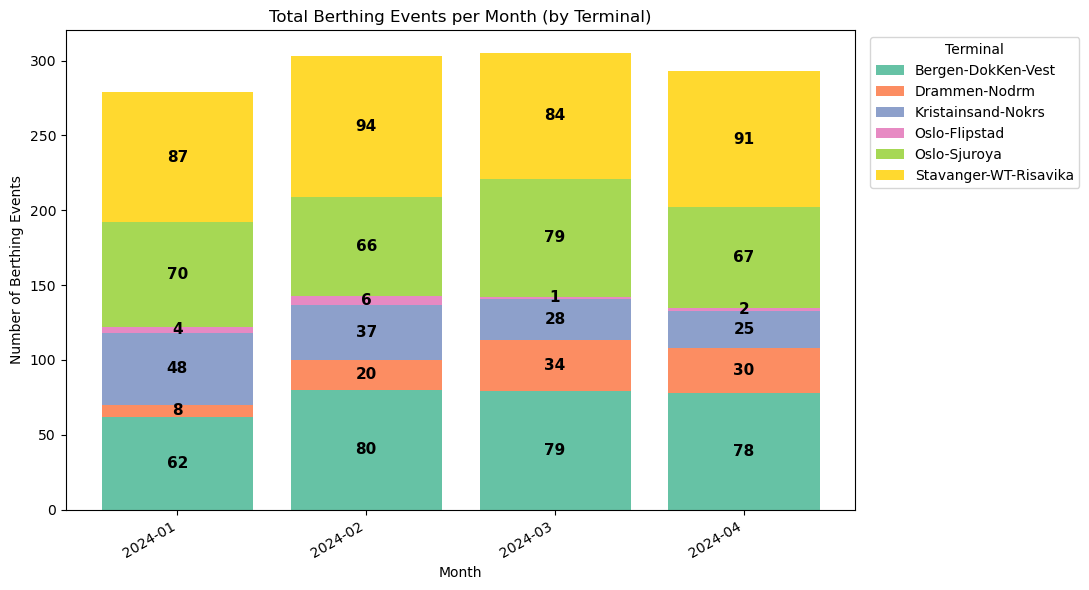

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare monthly data: count of berth events per month per terminal ---
summary_df['month'] = pd.to_datetime(summary_df['berth_entry_time']).dt.to_period('M').astype(str)
monthly = summary_df.groupby(['month', 'terminal']).size().unstack(fill_value=0).sort_index()

# --- Stacked bar chart ---
fig, ax = plt.subplots(figsize=(11,6))
bottom = np.zeros(len(monthly))

colors = plt.cm.Set2.colors  # nice color set
terminals = monthly.columns

for i, terminal in enumerate(terminals):
    bars = ax.bar(monthly.index, monthly[terminal], label=terminal, bottom=bottom, color=colors[i % len(colors)])
    # Add value labels in middle of each bar segment
    for j, value in enumerate(monthly[terminal]):
        if value > 0:
            ax.text(j, bottom[j]+value/2, str(int(value)), ha='center', va='center', color='black', fontsize=11, fontweight='bold')
    bottom += monthly[terminal]

ax.set_title("Total Berthing Events per Month (by Terminal)")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Berthing Events")
ax.legend(title="Terminal", bbox_to_anchor=(1.01,1), loc='upper left')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



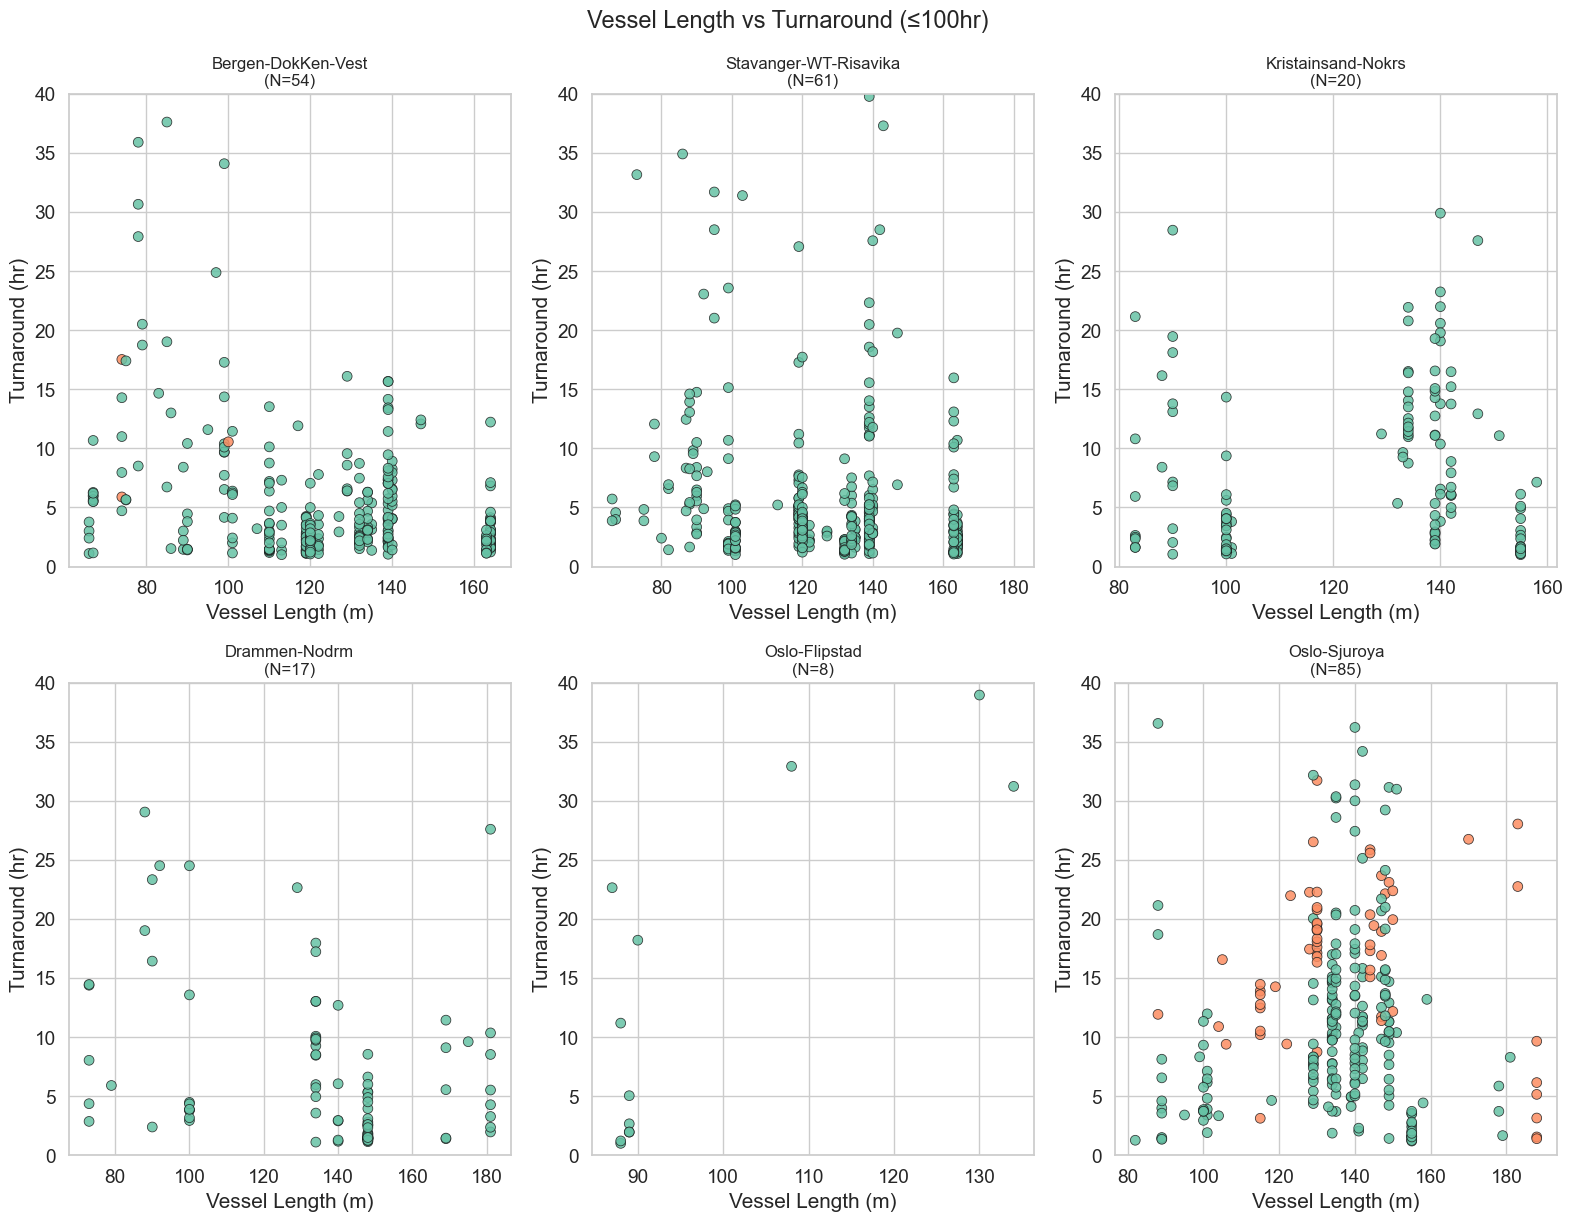

In [68]:
import numpy as np
sns.set_style("whitegrid")
plt.figure(figsize=(16,12))
for i, terminal in enumerate(terminal_name_map.values(), 1):
    df_term = summary_df[summary_df['terminal']==terminal]
    plt.subplot(2, 3, i)
    # color by vessel type for more insight
    sns.scatterplot(
        x=pd.to_numeric(df_term['length'], errors='coerce'),
        y=df_term['turnaround_minutes']/60,
        hue=df_term['ship_type'],  # only works if you have this column!
        palette='Set2', s=50, edgecolor='k', alpha=0.85, legend=False
    )
    plt.title(f"{terminal}\n(N={df_term['mmsi'].nunique()})", fontsize=12)
    plt.xlabel("Vessel Length (m)")
    plt.ylabel("Turnaround (hr)")
    plt.ylim(0, 40)  # ZOOM for detail, change as needed
plt.tight_layout()
plt.suptitle("Vessel Length vs Turnaround (≤100hr)", fontsize=17, y=1.02)
plt.show()


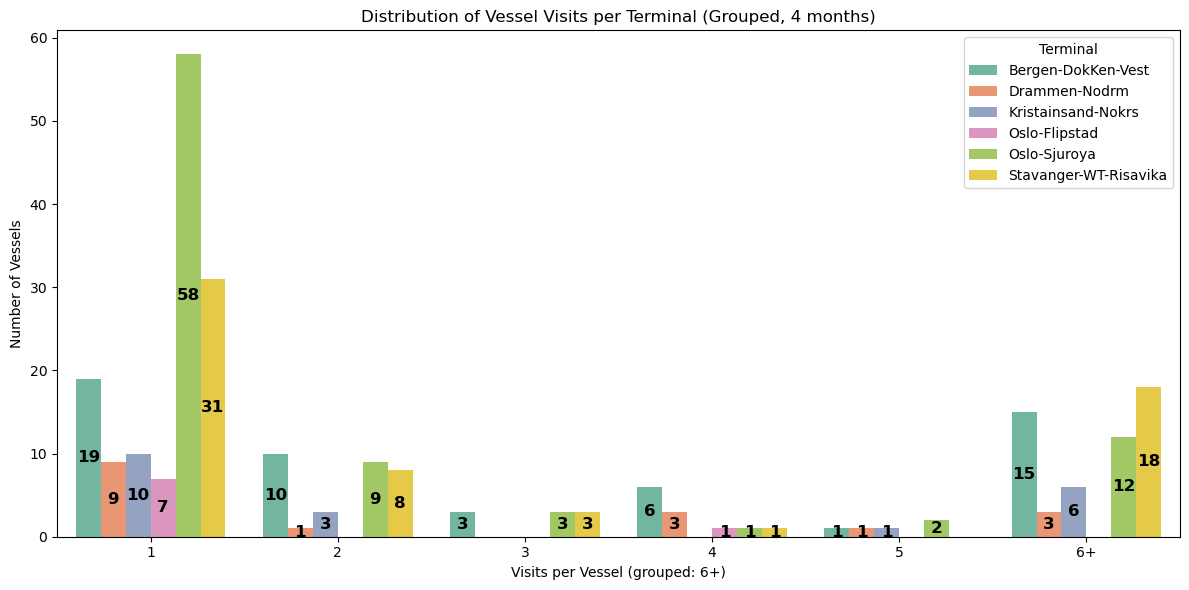

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Create visit count table ---
visit_dist = summary_df.groupby(['terminal','mmsi'])['visit_number'].nunique().reset_index()
visit_freq = visit_dist.groupby(['terminal','visit_number']).size().reset_index(name='num_vessels')

# Group high visit numbers into "6+"
visit_freq['visit_label'] = visit_freq['visit_number'].apply(lambda x: str(x) if x < 6 else '6+')
visit_freq_summary = visit_freq.groupby(['terminal','visit_label'])['num_vessels'].sum().reset_index()

# --- Barplot ---
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=visit_freq_summary, x='visit_label', y='num_vessels', hue='terminal',
    palette='Set2'
)
plt.xlabel("Visits per Vessel (grouped: 6+)")
plt.ylabel("Number of Vessels")
plt.title("Distribution of Vessel Visits per Terminal (Grouped, 4 months)")
plt.legend(title='Terminal', fontsize=10)

# --- Add numbers on bars ---
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



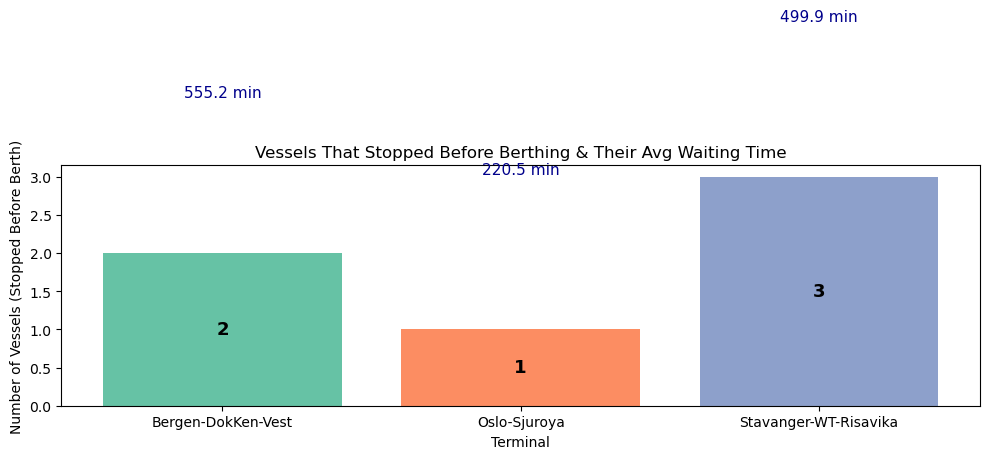

In [31]:
waited_vessels = summary_df[summary_df['waiting_time_minutes'].notnull()]
wait_counts = waited_vessels.groupby('terminal')['mmsi'].nunique().reset_index(name='NumStoppedBeforeBerth')
avg_wait = waited_vessels.groupby('terminal')['waiting_time_minutes'].mean().reset_index(name='AvgWaitTime')
wait_stats = pd.merge(wait_counts, avg_wait, on='terminal')

plt.figure(figsize=(10,6))
bars = plt.bar(wait_stats['terminal'], wait_stats['NumStoppedBeforeBerth'], color=sns.color_palette('Set2', len(wait_stats)))
for i, row in wait_stats.iterrows():
    plt.text(i, row['NumStoppedBeforeBerth']/2, str(int(row['NumStoppedBeforeBerth'])), ha='center', va='center', color='black', fontsize=13, fontweight='bold')
    plt.text(i, row['NumStoppedBeforeBerth']+2, f"{row['AvgWaitTime']:.1f} min", ha='center', va='bottom', color='darkblue', fontsize=11)
plt.title("Vessels That Stopped Before Berthing & Their Avg Waiting Time")
plt.ylabel("Number of Vessels (Stopped Before Berth)")
plt.xlabel("Terminal")
plt.tight_layout()
plt.show()